In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import talib as tl
from sklearn.decomposition import PCA
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
train_size = 150
test_size = 5
return_day = 10
extreme_val = 0
full_size = train_size + test_size + return_day 
# make return_day long gap between train and test set to avoid lookahead bias

In [4]:
data = pd.read_excel('USDCLP.xlsx', skiprows=4, index_col='Dates', parse_dates=True)
data.dropna(inplace=True)
data.columns = ['Open', 'High', 'Low', 'Close']
data = data['2004':] # before 2004 the data is not OHLC, but C
data['2018-01-08':'2018-01-13']

,Open,High,Low,Close
Dates,,,,
2018-01-08,606.37,608.47,604.58,605.31
2018-01-09,606.00,608.59,605.57,607.89
2018-01-10,607.66,610.70,606.23,609.32
2018-01-11,608.01,609.67,606.13,606.22
2018-01-12,603.17,605.81,602.86,603.18


In [5]:
new_data = data.resample('1W').pad()
new_data['Open'] = data['Open'].resample('1W').first()
new_data['Close'] = data['Close'].resample('1W').last()
new_data['High'] = data['High'].resample('1W').max()
new_data['Low'] = data['Low'].resample('1W').min()
new_data.dropna(inplace=True)
new_data.tail()

,Open,High,Low,Close
Dates,,,,
2018-01-07,612.19,612.45,601.80,605.78
2018-01-14,606.37,610.70,602.86,603.18
2018-01-21,599.58,608.82,599.31,608.21
2018-01-28,607.69,609.78,597.70,601.68
2018-02-04,603.65,607.37,596.31,597.03


In [6]:
data = new_data

In [7]:
oopen = data['Open'].values
high = data['High'].values
low = data['Low'].values
close = data['Close'].values

In [8]:
features_to_delete = data.columns.tolist()

# ROC

In [9]:
for i in [2, 5, 10, 20]:
    data[f'ROC {i}'] = tl.ROC(close, timeperiod=i)

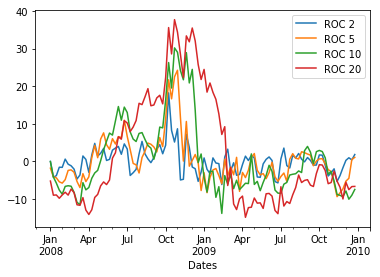

In [10]:
data['2008': '2009'][['ROC 2', 'ROC 5', 'ROC 10', 'ROC 20']].plot()

# Deviation from zero-lag exponential MA

In [11]:
for i in [10, 20, 40]:
    lag = (i-1)/2
    ema_data = 2*data['Close'] - data['Close'].shift(i).fillna(method='bfill')
    data['Deviation EMA ' + str(i)] = data['Close'] - tl.EMA(ema_data.values, timeperiod=i)

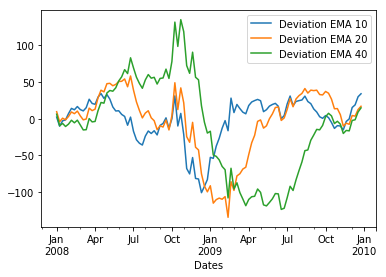

In [12]:
data['2008':'2009'][['Deviation EMA 10', 'Deviation EMA 20', 'Deviation EMA 40']].plot()

# MACD

In [13]:
for i, j, k in [(12, 16, 9), (3, 5, 2)]:
    macd, macdsignal, macdhist = tl.MACD(close, fastperiod=i, slowperiod=j, signalperiod=k)
    data[f'MACD ({i}, {j}, {k})'] = macd
#     data[f'MACD signal ({i}, {j}, {k})'] = macdsignal
#     data[f'MACD hist ({i}, {j}, {k})'] = macdhist

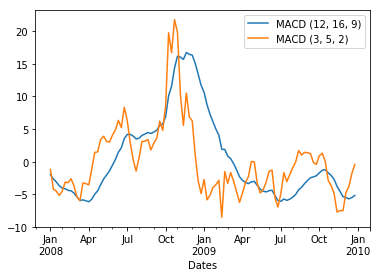

In [14]:
data['2008':'2009'][['MACD (12, 16, 9)', 'MACD (3, 5, 2)']].plot()

In [15]:
# data['2008'][['MACD signal (12, 16, 9)', 'MACD signal (3, 5, 2)']].plot()

In [16]:
# data['2008'][['MACD hist (14, 20, 12)', 'MACD hist (12, 16, 9)', 'MACD hist (3, 5, 2)']].plot()

# RSI

In [17]:
for i in [5, 10, 14, 20]:
    data[f'RSI {i}'] = tl.RSI(close, timeperiod=i)

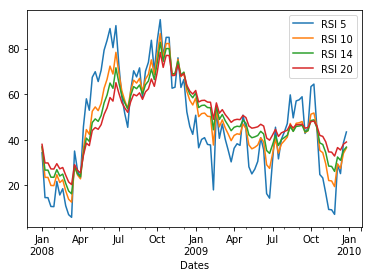

In [18]:
data['2008':'2009'][['RSI 5', 'RSI 10', 'RSI 14', 'RSI 20']].plot()

# SMA differences

In [19]:
for i, j in [(5, 10), (10, 20)]:
    data[f'SMA ({i}, {j}) diff'] = tl.SMA(close, timeperiod=i) - tl.SMA(close, timeperiod=j)

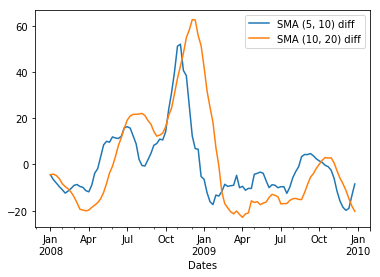

In [20]:
data['2008':'2009'][['SMA (5, 10) diff', 'SMA (10, 20) diff']].plot()

# ADX

In [21]:
data['ADX 14'] = tl.ADX(high, low, close, timeperiod=14)

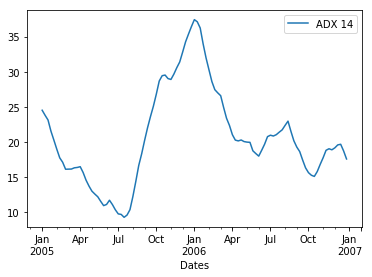

In [22]:
data['2005':'2006'][['ADX 14']].plot()

# CCI

In [23]:
data['CCI 14'] = tl.CCI(high, low, close, timeperiod=14)

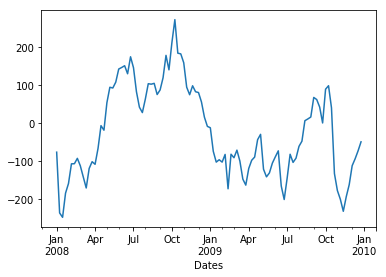

In [24]:
data['2008':'2009']['CCI 14'].plot()

# Y target value

In [25]:
data['Return'] = data['Close'].pct_change(return_day).shift(-return_day)*100
data['Extreme'] = data['Close'].pct_change(return_day).rolling(return_day).std()*100

In [26]:
data.dropna(inplace=True)
data.drop(columns=features_to_delete, inplace=True)
data.head()

,ROC 2,ROC 5,ROC 10,ROC 20,Deviation EMA 10,Deviation EMA 20,Deviation EMA 40,"MACD (12, 16, 9)","MACD (3, 5, 2)",RSI 5,RSI 10,RSI 14,RSI 20,"SMA (5, 10) diff","SMA (10, 20) diff",ADX 14,CCI 14,Return,Extreme
Dates,,,,,,,,,,,,,,,,,,,
2004-10-03,-0.950430,-3.565731,-4.773533,-5.258621,-3.145266,-33.071905,-39.414000,-1.063577,-3.861377,19.825401,34.272946,41.114504,46.984882,-11.395,-6.1890,23.131563,-149.550770,-1.968732,1.846438
2004-10-10,-2.877405,-4.189450,-7.175132,-7.218502,-1.318854,-33.379343,-46.271854,-1.860784,-4.879007,14.557762,29.792533,37.437672,44.189530,-12.000,-8.4765,23.788964,-163.745237,-3.726395,2.343418
2004-10-17,0.719663,-1.345001,-5.045621,-3.670886,15.480028,-16.183691,-34.079324,-1.949907,-2.230049,42.969704,42.352674,45.334744,48.982102,-10.425,-10.5515,23.417572,-96.015734,-7.769382,1.947023
2004-10-24,2.182123,-0.245801,-4.830767,-5.576237,18.242751,-11.263816,-34.076674,-1.982963,-0.983722,42.901381,42.320443,45.311144,48.965143,-7.635,-11.8440,22.543811,-59.526914,-8.706366,1.778628
2004-10-31,0.813075,0.057059,-2.818463,-5.431433,22.253160,-2.310119,-29.563178,-1.790757,0.429008,52.368375,46.817456,48.214271,50.759614,-5.785,-11.8615,21.732462,-39.499532,-7.046843,1.770833


### Features

In [27]:
feature_names = data.drop(['Return', 'Extreme'], axis=1).columns

# Train and test Random Forest

In [28]:
def to_class(y_vec, extreme):
    pos = y_vec > extreme
    neg = y_vec <= -1*extreme

    y_vec[:] = 'Neutral'
    y_vec[pos] = 'Pos'
    y_vec[neg] = 'Neg'
    return y_vec

In [29]:
def make_X_y(df):
    X = df.drop(['Return', 'Extreme'], axis=1)
    y = df['Return'].copy()
    ret = y.copy()
    y = to_class(y, extreme_val) # df['Extreme']
    return X, y, ret

In [30]:
def split_X_y(X, y, ret):
    X_train = X.iloc[:train_size]
    X_test = X.iloc[-test_size:]
    y_train = y.iloc[:train_size]
    y_test = y.iloc[-test_size:]
    train_ret = ret.iloc[:train_size]
    test_ret = ret.iloc[-test_size:]
    print('Split result before upsampling: {} -> {} + {}'.format(len(X), len(X_train), len(X_test)))
    
    last_q4 = int(train_size/4)
    last_q8 = int(train_size/8)
    last_q16 = int(train_size/16)
    
    X_train = pd.concat([X_train, X_train[-last_q4:], X_train[-last_q8:], X_train[-last_q16:]], ignore_index=True)
    y_train = pd.concat([y_train, y_train[-last_q4:], y_train[-last_q8:], y_train[-last_q16:]], ignore_index=True)
    train_ret = pd.concat([train_ret, train_ret[-last_q4:], train_ret[-last_q8:], train_ret[-last_q16:]], ignore_index=True)
    
    return X_train, X_test, y_train, y_test, train_ret, test_ret

In [31]:
def print_labels_distrib(y_train, y_test):
    def distrib_print(vec):
        print('---\nDistribution:\n' + str(vec.value_counts()))
        
    distrib_print(y_train)
    distrib_print(y_test)

In [32]:
def calculate_returns(ret, y_pred, log=True):
    longs = np.nansum(ret[y_pred == 'Pos'])
    shorts = np.nansum(-1*ret[y_pred == 'Neg'])
    ret_sum = longs + shorts
    if log:
        print(f'{longs} [long] + {shorts} [short] = {ret_sum}')
    return ret_sum

In [33]:
from sklearn.metrics import make_scorer
def custom_loss(y_true, y_pred, ret):
#     bad_sum     = -8*np.sum(((y_true == 'Pos') & (y_pred == 'Neg')) | ((y_true == 'Neg') & (y_pred == 'Pos')))
#     np_sum      = -2*np.sum(((y_true == 'Neutral') & (y_pred == 'Pos')) | ((y_true == 'Neutral') & (y_pred == 'Neg')))
#     pn_sum      = -1*np.sum(((y_true == 'Pos') & (y_pred == 'Neutral')) | ((y_true == 'Neg') & (y_pred == 'Neutral')))
#     good_sum    =  10*np.sum(((y_true == 'Pos') & (y_pred == 'Pos')) | ((y_true == 'Neg') & (y_pred == 'Neg')))
#     return bad_sum + np_sum + pn_sum + good_sum
    actual_returns = ret.iloc[y_true.index]
    return calculate_returns(actual_returns, y_pred, log=False) 

In [34]:
def print_results(y_test, y_pred):
    print('---\nClassification report\n', classification_report(y_test, y_pred))
    print('---\nConfusion matrix\n', str(confusion_matrix(y_test, y_pred)))

## Train and Test

In [35]:
def train_and_test(df):
    X, y, ret = make_X_y(df)
    X_train, X_test, y_train, y_test, train_ret, test_ret = split_X_y(X, y, ret)
    print_labels_distrib(y_train, y_test)
    
    forest = RandomForestClassifier(n_jobs=8, class_weight='balanced_subsample')
    pipe = Pipeline(steps=[('scaler', StandardScaler()), 
#                            ('pca', PCA()), 
                           ('forest', forest)])
    
    params = {'forest__n_estimators': [100],
              'forest__max_depth': [3,None],
              'forest__max_features': [3,5],
              'forest__min_samples_split': [2,5],
              'forest__min_samples_leaf': [5,10,20],
#               'pca__n_components': [0.3, 0.7],
             }
    scorer = make_scorer(custom_loss, greater_is_better=True, ret=train_ret)
    grid = GridSearchCV(estimator=pipe,
                        param_grid=params, 
                        scoring='accuracy', # scorer
                        cv=4)
    
    grid.fit(X_train, y_train)
    best_estimator = grid.best_estimator_
    best_params = grid.best_params_
    
    y_pred = best_estimator.predict(X_test)
    print_results(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    ret_sum = calculate_returns(test_ret, y_pred)
    
    param = {
        'accuracy':acc,
        'date': df.index[-1],
        'best_params': best_params,
        'features': best_estimator.steps[-1][1].feature_importances_,
        'ret_sum': ret_sum
    }
    test_params.append(param)

In [36]:
test_params = []

for i in range(0, len(data)-full_size, test_size):
    sub_data = data.iloc[i:i+full_size]
    from_date, to_date = sub_data.index[0], sub_data.index[-1]
    sep = 100*'='
    print(f'{sep}\nFrom {from_date} to {to_date}')
    train_and_test(sub_data)

From 2004-10-03 00:00:00 to 2007-11-25 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neg    158
Pos     56
Name: Return, dtype: int64
---
Distribution:
Neg    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         5
        Pos       0.00      0.00      0.00         0

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 5]
 [0 0]]
-26.749050570314992 [long] + 0.0 [short] = -26.749050570314992
From 2004-11-07 00:00:00 to 2007-12-30 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neg    163
Pos     51
Name: Return, dtype: int64
---
Distribution:
Neg    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      0.20      0.33         5
        Pos       0.00      0.00      0.00         0

avg / total       1.00      0.20      0.33         5

---
Confusion matrix
 [[1 4]
 [0 0]]
-32.5916251809764 [long] + 6.6871190247032475 [short] = -25.904506156273154
From 2004-12-12 00:00:00 to 2008-02-03 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neg    164
Pos     50
Name: Return, dtype: int64
---
Distribution:
Neg    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      0.80      0.89         5
        Pos       0.00      0.00      0.00         0

avg / total       1.00      0.80      0.89         5

---
Confusion matrix
 [[4 1]
 [0 0]]
-11.637618010167039 [long] + 24.992240286654855 [short] = 13.354622276487817
From 2005-01-16 00:00:00 to 2008-03-09 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neg    168
Pos     46
Name: Return, dtype: int64
---
Distribution:
Pos    3
Neg    2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.40      1.00      0.57         2
        Pos       0.00      0.00      0.00         3

avg / total       0.16      0.40      0.23         5

---
Confusion matrix
 [[2 0]
 [3 0]]
0.0 [long] + -2.810310823709461 [short] = -2.810310823709461
From 2005-02-20 00:00:00 to 2008-04-13 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neg    172
Pos     42
Name: Return, dtype: int64
---
Distribution:
Pos    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
        Pos       1.00      0.20      0.33         5

avg / total       1.00      0.20      0.33         5

---
Confusion matrix
 [[0 0]
 [4 1]]
10.906122814079344 [long] + -39.64472021140273 [short] = -28.73859739732338
From 2005-03-27 00:00:00 to 2008-05-18 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neg    174
Pos     40
Name: Return, dtype: int64
---
Distribution:
Pos    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
        Pos       1.00      0.40      0.57         5

avg / total       1.00      0.40      0.57         5

---
Confusion matrix
 [[0 0]
 [3 2]]
27.32957832301519 [long] + -18.863931778890564 [short] = 8.465646544124628
From 2005-05-01 00:00:00 to 2008-06-22 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neg    166
Pos     48
Name: Return, dtype: int64
---
Distribution:
Pos    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
        Pos       0.00      0.00      0.00         5

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 0]
 [5 0]]
0.0 [long] + -28.3932975527458 [short] = -28.3932975527458
From 2005-06-05 00:00:00 to 2008-07-27 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neg    148
Pos     66
Name: Return, dtype: int64
---
Distribution:
Pos    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
        Pos       0.00      0.00      0.00         5

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 0]
 [5 0]]
0.0 [long] + -38.13165915107959 [short] = -38.13165915107959
From 2005-07-10 00:00:00 to 2008-08-31 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neg    132
Pos     82
Name: Return, dtype: int64
---
Distribution:
Pos    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
        Pos       1.00      0.80      0.89         5

avg / total       1.00      0.80      0.89         5

---
Confusion matrix
 [[0 0]
 [1 4]]
102.80219126504768 [long] + -26.26112759643917 [short] = 76.54106366860852
From 2005-08-14 00:00:00 to 2008-10-05 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neg    117
Pos     97
Name: Return, dtype: int64
---
Distribution:
Pos    5
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Pos       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
109.41396126203819 [long] + 0.0 [short] = 109.41396126203819
From 2005-09-18 00:00:00 to 2008-11-09 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neg    108
Pos    106
Name: Return, dty

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         4
        Pos       0.20      1.00      0.33         1

avg / total       0.04      0.20      0.07         5

---
Confusion matrix
 [[0 4]
 [0 1]]
-13.817644814413466 [long] + 0.0 [short] = -13.817644814413466
From 2005-10-23 00:00:00 to 2008-12-14 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Pos    116
Neg     98
Name: Return, dtype: int64
---
Distribution:
Neg    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         5
        Pos       0.00      0.00      0.00         0

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 5]
 [0 0]]
-37.01047659522095 [long] + 0.0 [short] = -37.01047659522095
From 2005-11-27 00:00:00 to 2009-01-18 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Pos    125
Neg     89
Name: Return, dtype: int64
---
Distribution:
Neg    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         5
        Pos       0.00      0.00      0.00         0

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 5]
 [0 0]]
-29.663074036683554 [long] + 0.0 [short] = -29.663074036683554
From 2006-01-01 00:00:00 to 2009-02-22 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Pos    113
Neg    101
Name: Return, dtype: int64
---
Distribution:
Neg    4
Pos    1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         4
        Pos       0.20      1.00      0.33         1

avg / total       0.04      0.20      0.07         5

---
Confusion matrix
 [[0 4]
 [0 1]]
-22.937151452612394 [long] + 0.0 [short] = -22.937151452612394
From 2006-02-05 00:00:00 to 2009-03-29 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neg    118
Pos     96
Name: Return, dtype: int64
---
Distribution:
Neg    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         5
        Pos       0.00      0.00      0.00         0

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 5]
 [0 0]]
-23.879232103461646 [long] + 0.0 [short] = -23.879232103461646
From 2006-03-12 00:00:00 to 2009-05-03 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neg    129
Pos     85
Name: Return, dtype: int64
---
Distribution:
Neg    5
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
0.0 [long] + 33.715182335764695 [short] = 33.715182335764695
From 2006-04-16 00:00:00 to 2009-06-07 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neg    137
Pos     77
Name: Return, dtype: int64
--

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         5
        Pos       0.00      0.00      0.00         0

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 5]
 [0 0]]
-18.873290325766348 [long] + 0.0 [short] = -18.873290325766348
From 2006-05-21 00:00:00 to 2009-07-12 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neg    147
Pos     67
Name: Return, dtype: int64
---
Distribution:
Pos    3
Neg    2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.40      1.00      0.57         2
        Pos       0.00      0.00      0.00         3

avg / total       0.16      0.40      0.23         5

---
Confusion matrix
 [[2 0]
 [3 0]]
0.0 [long] + -5.372360604700466 [short] = -5.372360604700466
From 2006-06-25 00:00:00 to 2009-08-16 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neg    156
Pos     58
Name: Return, dtype: int64
---
Distribution:
Pos    4
Neg    1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.20      1.00      0.33         1
        Pos       0.00      0.00      0.00         4

avg / total       0.04      0.20      0.07         5

---
Confusion matrix
 [[1 0]
 [4 0]]
0.0 [long] + -5.304719134810664 [short] = -5.304719134810664
From 2006-07-30 00:00:00 to 2009-09-20 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neg    162
Pos     52
Name: Return, dtype: int64
---
Distribution:
Neg    5
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
0.0 [long] + 35.51544383697663 [short] = 35.51544383697663
From 2006-09-03 00:00:00 to 2009-10-25 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neg    154
Pos     60
Name: Return, dtype: int64
---
Di

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         2
        Pos       0.60      1.00      0.75         3

avg / total       0.36      0.60      0.45         5

---
Confusion matrix
 [[0 2]
 [0 3]]
15.166121926221809 [long] + 0.0 [short] = 15.166121926221809
From 2007-01-21 00:00:00 to 2010-03-14 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neg    150
Pos     64
Name: Return, dtype: int64
---
Distribution:
Pos    3
Neg    2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         2
        Pos       0.60      1.00      0.75         3

avg / total       0.36      0.60      0.45         5

---
Confusion matrix
 [[0 2]
 [0 3]]
8.020871723096723 [long] + 0.0 [short] = 8.020871723096723
From 2007-02-25 00:00:00 to 2010-04-18 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neg    132
Pos     82
Name: Return, dtype: int64
---
Distribution:
Pos    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
        Pos       1.00      0.20      0.33         5

avg / total       1.00      0.20      0.33         5

---
Confusion matrix
 [[0 0]
 [4 1]]
1.3384500187195725 [long] + -9.364482381907969 [short] = -8.026032363188396
From 2007-04-01 00:00:00 to 2010-05-23 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neg    124
Pos     90
Name: Return, dtype: int64
---
Distribution:
Neg    3
Pos    2
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       0.33      0.33      0.33         3
        Pos       0.00      0.00      0.00         2

avg / total       0.20      0.20      0.20         5

---
Confusion matrix
 [[1 2]
 [2 0]]
-6.981377077161444 [long] + -6.4588877970602425 [short] = -13.440264874221686
From 2007-05-06 00:00:00 to 2010-06-27 00:00:00
Split result be

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      0.20      0.33         5
        Pos       0.00      0.00      0.00         0

avg / total       1.00      0.20      0.33         5

---
Confusion matrix
 [[1 4]
 [0 0]]
-21.41889943826851 [long] + 7.718939041414618 [short] = -13.699960396853893
From 2007-06-10 00:00:00 to 2010-08-01 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neg    111
Pos    103
Name: Return, dtype: int64
---
Distribution:
Neg    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         5
        Pos       0.00      0.00      0.00         0

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 5]
 [0 0]]
-38.32188148867447 [long] + 0.0 [short] = -38.32188148867447
From 2007-07-15 00:00:00 to 2010-09-05 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neg    113
Pos    101
Name: Return, dtype: int64
---
Distribution:
Neg    5
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
0.0 [long] + 21.575716516882615 [short] = 21.575716516882615
From 2007-08-19 00:00:00 to 2010-10-10 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neg    119
Pos     95
Name: Return, dtype: int64
---


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.60      1.00      0.75         3
        Pos       0.00      0.00      0.00         2

avg / total       0.36      0.60      0.45         5

---
Confusion matrix
 [[3 0]
 [2 0]]
0.0 [long] + 2.437416736601028 [short] = 2.437416736601028
From 2007-12-02 00:00:00 to 2011-01-23 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neg    141
Pos     73
Name: Return, dtype: int64
---
Distribution:
Neg    3
Pos    2
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         3
        Pos       0.00      0.00      0.00         2

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 3]
 [2 0]]
-8.940735790748601 [long] + -3.212176827322044 [short] = -12.152912618070644
From 2008-01-06 00:00:00 to 2011-02-27 00:00:00
Split result before upsampling: 1

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         5
        Pos       0.00      0.00      0.00         0

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 5]
 [0 0]]
-9.044587796886649 [long] + 0.0 [short] = -9.044587796886649
From 2008-02-10 00:00:00 to 2011-04-03 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neg    127
Pos     87
Name: Return, dtype: int64
---
Distribution:
Neg    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      0.20      0.33         5
        Pos       0.00      0.00      0.00         0

avg / total       1.00      0.20      0.33         5

---
Confusion matrix
 [[1 4]
 [0 0]]
-9.229475298982713 [long] + 1.7190291058106544 [short] = -7.510446193172059
From 2008-03-16 00:00:00 to 2011-05-08 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neg    130
Pos     84
Name: Return, dtype: int64
---
Distribution:
Pos    3
Neg    2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.40      1.00      0.57         2
        Pos       0.00      0.00      0.00         3

avg / total       0.16      0.40      0.23         5

---
Confusion matrix
 [[2 0]
 [3 0]]
0.0 [long] + -0.006046244786805932 [short] = -0.006046244786805932
From 2008-04-20 00:00:00 to 2011-06-12 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neg    137
Pos     77
Name: Return, dtype: int64
---
Distribution:
Neg    3
Pos    2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.60      1.00      0.75         3
        Pos       0.00      0.00      0.00         2

avg / total       0.36      0.60      0.45         5

---
Confusion matrix
 [[3 0]
 [2 0]]
0.0 [long] + 2.812274203662357 [short] = 2.812274203662357
From 2008-05-25 00:00:00 to 2011-07-17 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neg    147
Pos     67
Name: Return, dtype: int64
---
Distribution:
Pos    3
Neg    2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.40      1.00      0.57         2
        Pos       0.00      0.00      0.00         3

avg / total       0.16      0.40      0.23         5

---
Confusion matrix
 [[2 0]
 [3 0]]
0.0 [long] + -12.342828315527187 [short] = -12.342828315527187
From 2008-06-29 00:00:00 to 2011-08-21 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neg    143
Pos     71
Name: Return, dtype: int64
---
Distribution:
Pos    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
        Pos       1.00      0.20      0.33         5

avg / total       1.00      0.20      0.33         5

---
Confusion matrix
 [[0 0]
 [4 1]]
13.261539133663902 [long] + -33.91153028746185 [short] = -20.64999115379795
From 2008-08-03 00:00:00 to 2011-09-25 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neg    141
Pos     73
Name: Return, dtype: int64
---
Distribution:
Pos    4
Neg    1
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       0.25      1.00      0.40         1
        Pos       1.00      0.25      0.40         4

avg / total       0.85      0.40      0.40         5

---
Confusion matrix
 [[1 0]
 [3 1]]
8.24022953527801 [long] + -24.54117273561257 [short] = -16.300943200334558
From 2008-09-07 00:00:00 to 2011-10-30 00:00:00
Split result befor

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.80      1.00      0.89         4
        Pos       0.00      0.00      0.00         1

avg / total       0.64      0.80      0.71         5

---
Confusion matrix
 [[4 0]
 [1 0]]
0.0 [long] + 21.002631567217442 [short] = 21.002631567217442
From 2008-11-16 00:00:00 to 2012-01-08 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neg    122
Pos     92
Name: Return, dtype: int64
---
Distribution:
Neg    5
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
0.0 [long] + 31.68683139178322 [short] = 31.68683139178322
From 2008-12-21 00:00:00 to 2012-02-12 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neg    117
Pos     97
Name: Return, dtype: int64
---
Di

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.60      1.00      0.75         3
        Pos       0.00      0.00      0.00         2

avg / total       0.36      0.60      0.45         5

---
Confusion matrix
 [[3 0]
 [2 0]]
0.0 [long] + 0.8989622119769058 [short] = 0.8989622119769058
From 2009-01-25 00:00:00 to 2012-03-18 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neg    121
Pos     93
Name: Return, dtype: int64
---
Distribution:
Pos    4
Neg    1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.20      1.00      0.33         1
        Pos       0.00      0.00      0.00         4

avg / total       0.04      0.20      0.07         5

---
Confusion matrix
 [[1 0]
 [4 0]]
0.0 [long] + -11.33100237038732 [short] = -11.33100237038732
From 2009-03-01 00:00:00 to 2012-04-22 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neg    133
Pos     81
Name: Return, dtype: int64
---
Distribution:
Pos    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
        Pos       0.00      0.00      0.00         5

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 0]
 [5 0]]
0.0 [long] + -18.91360642634343 [short] = -18.91360642634343
From 2009-04-05 00:00:00 to 2012-05-27 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neg    128
Pos     86
Name: Return, dtype: int64
---
Distribution:
Pos    3
Neg    2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.40      1.00      0.57         2
        Pos       0.00      0.00      0.00         3

avg / total       0.16      0.40      0.23         5

---
Confusion matrix
 [[2 0]
 [3 0]]
0.0 [long] + 4.909263461096702 [short] = 4.909263461096702
From 2009-05-10 00:00:00 to 2012-07-01 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neg    119
Pos     95
Name: Return, dtype: int64
---
Distribution:
Neg    5
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
0.0 [long] + 24.67760592637193 [short] = 24.67760592637193
From 2009-06-14 00:00:00 to 2012-08-05 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Pos    108
Neg    106
Name: Return, dtype: int64
---
Dist

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      0.80      0.89         5
        Pos       0.00      0.00      0.00         0

avg / total       1.00      0.80      0.89         5

---
Confusion matrix
 [[4 1]
 [0 0]]
-2.930290575220329 [long] + 13.103661461552273 [short] = 10.173370886331943
From 2009-07-19 00:00:00 to 2012-09-09 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Pos    107
Neg    107
Name: Return, dtype: int64
---
Distribution:
Neg    4
Pos    1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         4
        Pos       0.20      1.00      0.33         1

avg / total       0.04      0.20      0.07         5

---
Confusion matrix
 [[0 4]
 [0 1]]
0.20837390596913918 [long] + 0.0 [short] = 0.20837390596913918
From 2009-08-23 00:00:00 to 2012-10-14 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neg    121
Pos     93
Name: Return, dtype: int64
---
Distribution:
Pos    5
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Pos       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
5.1623128839761945 [long] + 0.0 [short] = 5.1623128839761945
From 2009-09-27 00:00:00 to 2012-11-18 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neg    131
Pos     83
Name: Return, dtype: int64
--

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      0.20      0.33         5
        Pos       0.00      0.00      0.00         0

avg / total       1.00      0.20      0.33         5

---
Confusion matrix
 [[1 4]
 [0 0]]
-4.605280416931734 [long] + 0.828261278785225 [short] = -3.777019138146509
From 2009-12-06 00:00:00 to 2013-01-27 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neg    116
Pos     98
Name: Return, dtype: int64
---
Distribution:
Neg    3
Pos    2
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      0.67      0.80         3
        Pos       0.67      1.00      0.80         2

avg / total       0.87      0.80      0.80         5

---
Confusion matrix
 [[2 1]
 [0 2]]
-0.04776310697517383 [long] + 2.264319650152302 [short] = 2.2165565431771284
From 2010-01-10 00:00:00 to 2013-03-03 00:00:00
Split result befo

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
        Pos       1.00      0.20      0.33         5

avg / total       1.00      0.20      0.33         5

---
Confusion matrix
 [[0 0]
 [4 1]]
5.032519458364426 [long] + -17.747262578884282 [short] = -12.714743120519856
From 2010-03-21 00:00:00 to 2013-05-12 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neg    139
Pos     75
Name: Return, dtype: int64
---
Distribution:
Pos    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
        Pos       0.00      0.00      0.00         5

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 0]
 [5 0]]
0.0 [long] + -36.37211329440942 [short] = -36.37211329440942
From 2010-04-25 00:00:00 to 2013-06-16 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neg    140
Pos     74
Name: Return, dtype: int64
---
Distribution:
Pos    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
        Pos       0.00      0.00      0.00         5

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 0]
 [5 0]]
0.0 [long] + -17.415692979604856 [short] = -17.415692979604856
From 2010-05-30 00:00:00 to 2013-07-21 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neg    124
Pos     90
Name: Return, dtype: int64
---
Distribution:
Neg    4
Pos    1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.80      1.00      0.89         4
        Pos       0.00      0.00      0.00         1

avg / total       0.64      0.80      0.71         5

---
Confusion matrix
 [[4 0]
 [1 0]]
0.0 [long] + 2.628793115650574 [short] = 2.628793115650574
From 2010-07-04 00:00:00 to 2013-08-25 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Pos    107
Neg    107
Name: Return, dtype: int64
---
Distribution:
Neg    4
Pos    1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.80      1.00      0.89         4
        Pos       0.00      0.00      0.00         1

avg / total       0.64      0.80      0.71         5

---
Confusion matrix
 [[4 0]
 [1 0]]
0.0 [long] + 6.695218999881948 [short] = 6.695218999881948
From 2010-08-08 00:00:00 to 2013-09-29 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Pos    115
Neg     99
Name: Return, dtype: int64
---
Distribution:
Pos    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
        Pos       0.00      0.00      0.00         5

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 0]
 [5 0]]
0.0 [long] + -19.054330037254054 [short] = -19.054330037254054
From 2010-09-12 00:00:00 to 2013-11-03 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Pos    108
Neg    106
Name: Return, dtype: int64
---
Distribution:
Pos    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
        Pos       1.00      0.40      0.57         5

avg / total       1.00      0.40      0.57         5

---
Confusion matrix
 [[0 0]
 [3 2]]
7.3291781879544216 [long] + -18.07406109869676 [short] = -10.744882910742337
From 2010-10-17 00:00:00 to 2013-12-08 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neg    111
Pos    103
Name: Return, dtype: int64
---
Distribution:
Pos    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
        Pos       1.00      0.80      0.89         5

avg / total       1.00      0.80      0.89         5

---
Confusion matrix
 [[0 0]
 [1 4]]
20.61427528065767 [long] + -4.041901937299186 [short] = 16.572373343358482
From 2010-11-21 00:00:00 to 2014-01-12 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Pos    113
Neg    101
Name: Return, dtype: int64
---
Distribution:
Pos    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
        Pos       1.00      0.60      0.75         5

avg / total       1.00      0.60      0.75         5

---
Confusion matrix
 [[0 0]
 [2 3]]
18.837011200062534 [long] + -13.435035975976039 [short] = 5.401975224086495
From 2010-12-26 00:00:00 to 2014-02-16 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Pos    123
Neg     91
Name: Return, dtype: int64
---
Distribution:
Pos    4
Neg    1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.20      1.00      0.33         1
        Pos       0.00      0.00      0.00         4

avg / total       0.04      0.20      0.07         5

---
Confusion matrix
 [[1 0]
 [4 0]]
0.0 [long] + -4.67008228734972 [short] = -4.67008228734972
From 2011-01-30 00:00:00 to 2014-03-23 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Pos    132
Neg     82
Name: Return, dtype: int64
---
Distribution:
Neg    4
Pos    1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.80      1.00      0.89         4
        Pos       0.00      0.00      0.00         1

avg / total       0.64      0.80      0.71         5

---
Confusion matrix
 [[4 0]
 [1 0]]
0.0 [long] + 7.229654569963306 [short] = 7.229654569963306
From 2011-03-06 00:00:00 to 2014-04-27 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Pos    139
Neg     75
Name: Return, dtype: int64
---
Distribution:
Neg    3
Pos    2
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      0.33      0.50         3
        Pos       0.50      1.00      0.67         2

avg / total       0.80      0.60      0.57         5

---
Confusion matrix
 [[1 2]
 [0 2]]
-1.519876692062716 [long] + 0.08542969318015015 [short] = -1.4344469988825659
From 2011-04-10 00:00:00 to 2014-06-01 00:00:00
Split result before upsampling: 

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         1
        Pos       0.80      1.00      0.89         4

avg / total       0.64      0.80      0.71         5

---
Confusion matrix
 [[0 1]
 [0 4]]
11.324137785150112 [long] + 0.0 [short] = 11.324137785150112
From 2011-05-15 00:00:00 to 2014-07-06 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Pos    129
Neg     85
Name: Return, dtype: int64
---
Distribution:
Pos    5
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Pos       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
29.492655085835697 [long] + 0.0 [short] = 29.492655085835697
From 2011-06-19 00:00:00 to 2014-08-10 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Pos    125
Neg     89
Name: Return, dtype: int64
---


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         1
        Pos       0.80      1.00      0.89         4

avg / total       0.64      0.80      0.71         5

---
Confusion matrix
 [[0 1]
 [0 4]]
2.2650053493968425 [long] + 0.0 [short] = 2.2650053493968425
From 2011-08-28 00:00:00 to 2014-10-19 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Pos    134
Neg     80
Name: Return, dtype: int64
---
Distribution:
Pos    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
        Pos       0.00      0.00      0.00         5

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 0]
 [5 0]]
0.0 [long] + -14.662890025817866 [short] = -14.662890025817866
From 2011-10-02 00:00:00 to 2014-11-23 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Pos    139
Neg     75
Name: Return, dtype: int64
---
Distribution:
Pos    5
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Pos       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
30.103327387344823 [long] + 0.0 [short] = 30.103327387344823
From 2011-11-06 00:00:00 to 2014-12-28 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Pos    140
Neg     74
Name: Return, dtype: int64
--

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      0.20      0.33         5
        Pos       0.00      0.00      0.00         0

avg / total       1.00      0.20      0.33         5

---
Confusion matrix
 [[1 4]
 [0 0]]
-8.786249689047764 [long] + 2.2507576966023346 [short] = -6.535491992445429
From 2012-02-19 00:00:00 to 2015-04-12 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Pos    156
Neg     58
Name: Return, dtype: int64
---
Distribution:
Pos    3
Neg    2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         2
        Pos       0.60      1.00      0.75         3

avg / total       0.36      0.60      0.45         5

---
Confusion matrix
 [[0 2]
 [0 3]]
-0.19488185233020872 [long] + 0.0 [short] = -0.19488185233020872
From 2012-03-25 00:00:00 to 2015-05-17 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Pos    148
Neg     66
Name: Return, dtype: int64
---
Distribution:
Pos    5
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Pos       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
30.967339413855633 [long] + 0.0 [short] = 30.967339413855633
From 2012-04-29 00:00:00 to 2015-06-21 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Pos    129
Neg     85
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
        Pos       0.00      0.00      0.00         5

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 0]
 [5 0]]
0.0 [long] + -12.570938971872646 [short] = -12.570938971872646
From 2012-09-16 00:00:00 to 2015-11-08 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Pos    159
Neg     55
Name: Return, dtype: int64
---
Distribution:
Pos    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
        Pos       0.00      0.00      0.00         5

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 0]
 [5 0]]
0.0 [long] + -19.729199925771844 [short] = -19.729199925771844
From 2012-10-21 00:00:00 to 2015-12-13 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Pos    152
Neg     62
Name: Return, dtype: int64
---
Distribution:
Pos    3
Neg    2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.40      1.00      0.57         2
        Pos       0.00      0.00      0.00         3

avg / total       0.16      0.40      0.23         5

---
Confusion matrix
 [[2 0]
 [3 0]]
0.0 [long] + -0.031920433077303745 [short] = -0.031920433077303745
From 2012-11-25 00:00:00 to 2016-01-17 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Pos    157
Neg     57
Name: Return, dtype: int64
---
Distribution:
Neg    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      0.40      0.57         5
        Pos       0.00      0.00      0.00         0

avg / total       1.00      0.40      0.57         5

---
Confusion matrix
 [[2 3]
 [0 0]]
-7.43190992950189 [long] + 14.049185728512747 [short] = 6.617275799010857
From 2012-12-30 00:00:00 to 2016-02-21 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Pos    169
Neg     45
Name: Return, dtype: int64
---
Distribution:
Neg    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         5
        Pos       0.00      0.00      0.00         0

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 5]
 [0 0]]
-26.83692502196251 [long] + 0.0 [short] = -26.83692502196251
From 2013-02-03 00:00:00 to 2016-03-27 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Pos    169
Neg     45
Name: Return, dtype: int64
---
Distribution:
Pos    4
Neg    1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         1
        Pos       0.80      1.00      0.89         4

avg / total       0.64      0.80      0.71         5

---
Confusion matrix
 [[0 1]
 [0 4]]
0.6921325121222788 [long] + 0.0 [short] = 0.6921325121222788
From 2013-03-10 00:00:00 to 2016-05-01 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Pos    153
Neg     61
Name: Return, dtype: int64
---
Distribution:
Pos    3
Neg    2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         2
        Pos       0.60      1.00      0.75         3

avg / total       0.36      0.60      0.45         5

---
Confusion matrix
 [[0 2]
 [0 3]]
2.9990447426706868 [long] + 0.0 [short] = 2.9990447426706868
From 2013-04-14 00:00:00 to 2016-06-05 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Pos    136
Neg     78
Name: Return, dtype: int64
---
Distribution:
Neg    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         5
        Pos       0.00      0.00      0.00         0

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 5]
 [0 0]]
-22.014720757402287 [long] + 0.0 [short] = -22.014720757402287
From 2013-05-19 00:00:00 to 2016-07-10 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Pos    137
Neg     77
Name: Return, dtype: int64
---
Distribution:
Neg    3
Pos    2
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         3
        Pos       0.40      1.00      0.57         2

avg / total       0.16      0.40      0.23         5

---
Confusion matrix
 [[0 3]
 [0 2]]
-3.138047366505858 [long] + 0.0 [short] = -3.138047366505858
From 2013-06-23 00:00:00 to 2016-08-14 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Pos    139
Neg     75
Name: Return, dtype: int64
---
Distribution:
Pos    5
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Pos       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
9.206909991374545 [long] + 0.0 [short] = 9.206909991374545
From 2013-07-28 00:00:00 to 2016-09-18 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Pos    129
Neg     85
Name: Return, dtype: int64
---
Di

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         3
        Pos       0.40      1.00      0.57         2

avg / total       0.16      0.40      0.23         5

---
Confusion matrix
 [[0 3]
 [0 2]]
-8.773663625974649 [long] + 0.0 [short] = -8.773663625974649
From 2013-11-10 00:00:00 to 2017-01-01 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Pos    132
Neg     82
Name: Return, dtype: int64
---
Distribution:
Neg    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         5
        Pos       0.00      0.00      0.00         0

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 5]
 [0 0]]
-13.114170265854984 [long] + 0.0 [short] = -13.114170265854984
From 2013-12-15 00:00:00 to 2017-02-05 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Pos    139
Neg     75
Name: Return, dtype: int64
---
Distribution:
Pos    4
Neg    1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         1
        Pos       0.80      1.00      0.89         4

avg / total       0.64      0.80      0.71         5

---
Confusion matrix
 [[0 1]
 [0 4]]
2.2487292705384854 [long] + 0.0 [short] = 2.2487292705384854
From 2014-01-19 00:00:00 to 2017-03-12 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Pos    133
Neg     81
Name: Return, dtype: int64
---
Distribution:
Pos    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
        Pos       1.00      0.80      0.89         5

avg / total       1.00      0.80      0.89         5

---
Confusion matrix
 [[0 0]
 [1 4]]
11.535873485484814 [long] + -0.7876506024096397 [short] = 10.748222883075174
From 2014-02-23 00:00:00 to 2017-04-16 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Pos    117
Neg     97
Name: Return, dtype: int64
---
Distribution:
Pos    5
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         0
        Pos       0.00      0.00      0.00         5

avg / total       0.00      0.00      0.00         5

---
Confusion matrix
 [[0 0]
 [5 0]]
0.0 [long] + -6.491310018599705 [short] = -6.491310018599705
From 2014-03-30 00:00:00 to 2017-05-21 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Pos    128
Neg     86
Name: Return, dtype: int64
---
Distribution:
Neg    4
Pos    1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.80      1.00      0.89         4
        Pos       0.00      0.00      0.00         1

avg / total       0.64      0.80      0.71         5

---
Confusion matrix
 [[4 0]
 [1 0]]
0.0 [long] + 5.725960267042973 [short] = 5.725960267042973
From 2014-05-04 00:00:00 to 2017-06-25 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Pos    141
Neg     73
Name: Return, dtype: int64
---
Distribution:
Neg    5
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
0.0 [long] + 19.25294634843069 [short] = 19.25294634843069
From 2014-06-08 00:00:00 to 2017-07-30 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Pos    147
Neg     67
Name: Return, dtype: int64
---
Dist

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       1.00      0.40      0.57         5
        Pos       0.00      0.00      0.00         0

avg / total       1.00      0.40      0.57         5

---
Confusion matrix
 [[2 3]
 [0 0]]
-10.157755320851258 [long] + 12.812251886919324 [short] = 2.6544965660680653
From 2014-07-13 00:00:00 to 2017-09-03 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Pos    138
Neg     76
Name: Return, dtype: int64
---
Distribution:
Neg    4
Pos    1
Name: Return, dtype: int64


C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Classification report
              precision    recall  f1-score   support

        Neg       0.00      0.00      0.00         4
        Pos       0.20      1.00      0.33         1

avg / total       0.04      0.20      0.07         5

---
Confusion matrix
 [[0 4]
 [0 1]]
-7.528325205046093 [long] + 0.0 [short] = -7.528325205046093
From 2014-08-17 00:00:00 to 2017-10-08 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Pos    119
Neg     95
Name: Return, dtype: int64
---
Distribution:
Pos    5
Name: Return, dtype: int64
---
Classification report
              precision    recall  f1-score   support

        Pos       1.00      1.00      1.00         5

avg / total       1.00      1.00      1.00         5

---
Confusion matrix
 [[5]]
9.25738669340981 [long] + 0.0 [short] = 9.25738669340981
From 2014-09-21 00:00:00 to 2017-11-12 00:00:00
Split result before upsampling: 165 -> 150 + 5
---
Distribution:
Neg    108
Pos    106
Name: Return, dtype: int64
---
Dist

C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [37]:
indexes = [d['date'] for d in test_params]

### Random Forest parameters with Accuracy and Returns

In [38]:
params = pd.DataFrame([d['best_params'] for d in test_params], index=indexes)
params['Sum of return'] = [d['ret_sum'] for d in test_params]
params['Accuracy'] = [d['accuracy'] for d in test_params]

In [39]:
params.sort_values('Sum of return', ascending=False)

,forest__max_depth,forest__max_features,forest__min_samples_leaf,forest__min_samples_split,forest__n_estimators,Sum of return,Accuracy
2008-10-05,3.0,5,10,2,100,109.413961,1.0
2008-08-31,3.0,5,10,2,100,76.541064,0.8
2015-06-21,NaN,5,10,2,100,47.323671,1.0
2009-10-25,NaN,5,5,5,100,39.463092,1.0
2009-09-20,NaN,5,5,5,100,35.515444,1.0
2015-07-26,3.0,3,10,5,100,35.211253,1.0
2009-05-03,3.0,3,10,5,100,33.715182,1.0
2012-01-08,NaN,5,5,5,100,31.686831,1.0
2015-05-17,3.0,3,20,5,100,30.967339,1.0
2014-11-23,3.0,5,5,2,100,30.103327,1.0


In [40]:
params.describe()

,forest__max_depth,forest__max_features,forest__min_samples_leaf,forest__min_samples_split,forest__n_estimators,Sum of return,Accuracy
count,35.0,105.000000,105.000000,105.000000,105.0,105.000000,105.000000
mean,3.0,3.933333,8.095238,3.457143,100.0,0.616149,0.466667
std,0.0,1.002561,5.387885,1.506579,0.0,22.118732,0.363389
min,3.0,3.000000,5.000000,2.000000,100.0,-38.321881,0.000000
25%,3.0,3.000000,5.000000,2.000000,100.0,-12.714743,0.200000
50%,3.0,3.000000,5.000000,2.000000,100.0,-0.194882,0.400000
75%,3.0,5.000000,10.000000,5.000000,100.0,9.206910,0.800000
max,3.0,5.000000,20.000000,5.000000,100.0,109.413961,1.000000


In [41]:
params['Sum of return'].sum()

64.695641294958591

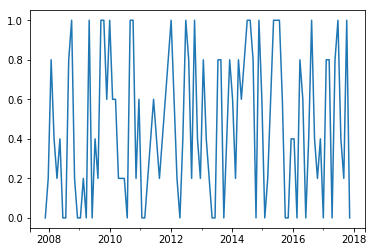

In [42]:
params['Accuracy'].plot()

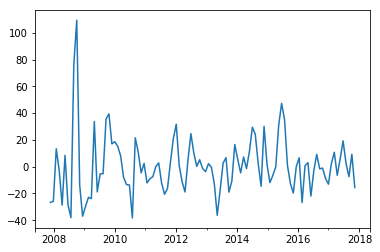

In [43]:
params['Sum of return'].plot()

### Feature importances

In [44]:
features = pd.DataFrame([d['features'] for d in test_params], index=indexes, columns=feature_names)

In [45]:
features.idxmax(axis=1).value_counts()

ADX 14               29
MACD (12, 16, 9)     25
SMA (10, 20) diff    19
Deviation EMA 40     13
Deviation EMA 20     10
ROC 20                5
SMA (5, 10) diff      2
RSI 20                1
RSI 14                1
dtype: int64

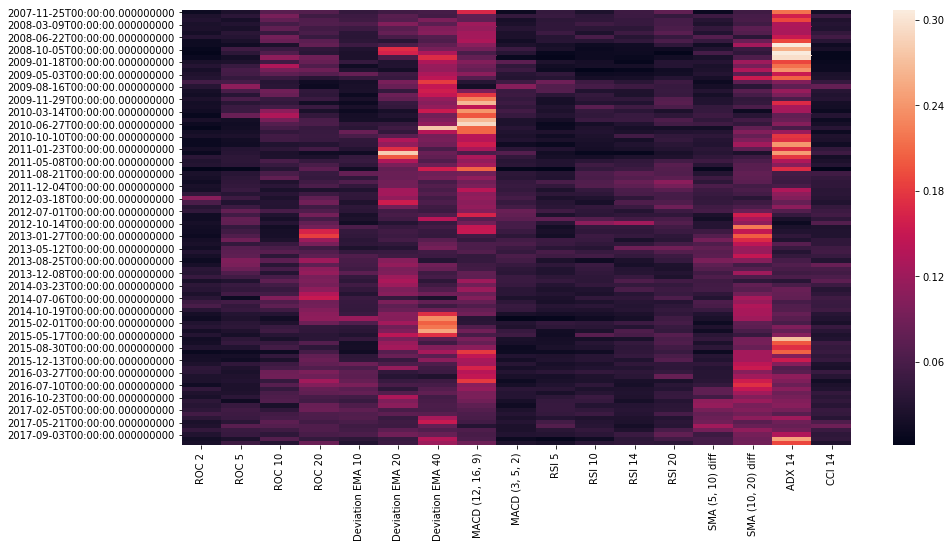

In [46]:
plt.figure(figsize=(15,8))
sns.heatmap(features)

C:\DEV\Anaconda3\envs\trading\lib\site-packages\seaborn\categorical.py:598: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
C:\DEV\Anaconda3\envs\trading\lib\site-packages\seaborn\categorical.py:826: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


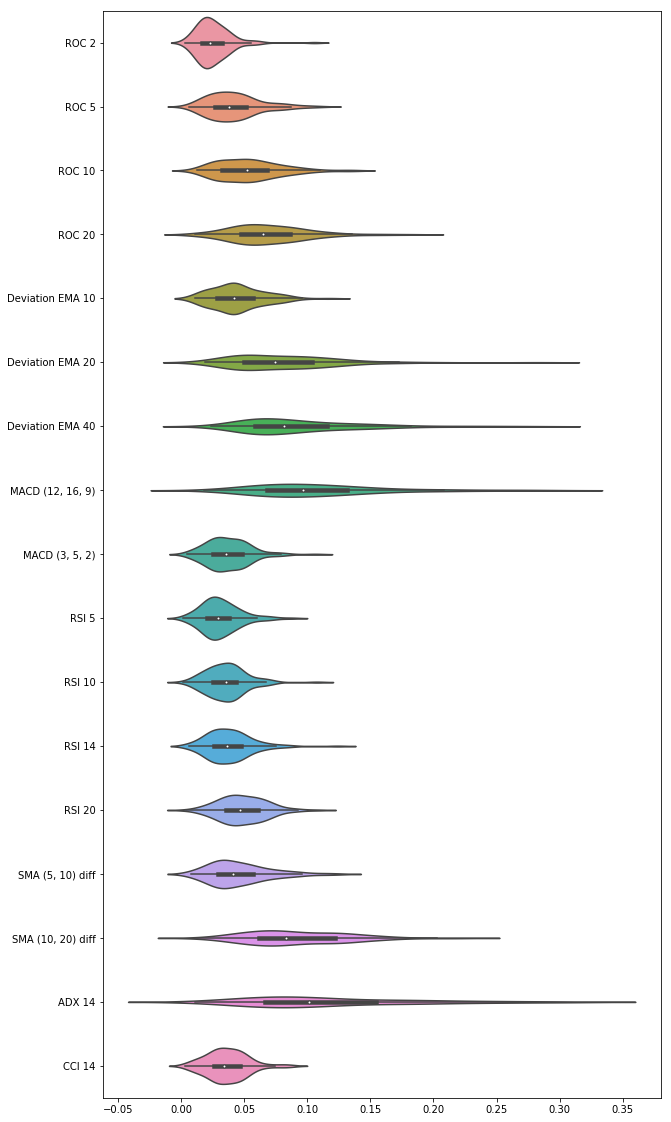

In [47]:
plt.figure(figsize=(10,20))
sns.violinplot(data=features, orient='h')